# **Banking Client Segmentation using K-Medoids**

This notebook implements a **complete clustering pipeline** for **banking clients segmentation** using the **K-Medoids algorithm**.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply K-Medoids Clustering**
4. **Evaluate Clustering Performance**
5. **Visualize Results using t-SNE**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [80]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    df = data.drop(columns=['ID'])

# Display first 5 rows
df.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


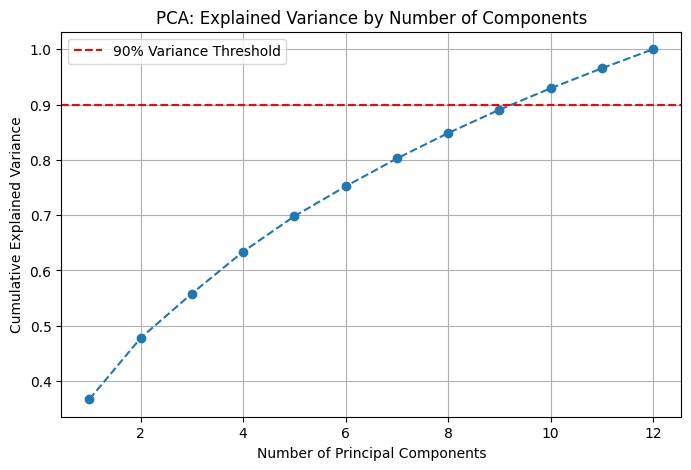

Processed Data Shape: (5000, 26)


In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

# Load dataset
df_cleaned = df.copy()

# Identify categorical and numerical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

numerical_features = df_cleaned[numerical_columns]
categorical_features = df_cleaned[categorical_columns]

# Handle Outliers using Winsorization (Clipping extreme 1%)
for col in numerical_features.columns:
    numerical_features.loc[:, col] = winsorize(numerical_features[col], limits=[0.01, 0.01])

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

# Compute Correlation Matrix and Identify Highly Correlated Features
corr_matrix = numerical_features.corr().abs()
high_corr_var = np.where(corr_matrix > 0.85)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_var) if i != j]

# Drop redundant numerical features
features_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
numerical_features_reduced = numerical_features.drop(columns=features_to_drop)
X_num_scaled_reduced = scaler.fit_transform(numerical_features_reduced)

# PCA for Dimensionality Reduction
pca = PCA()
pca.fit(X_num_scaled_reduced)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 90% variance
optimal_components = np.argmax(explained_variance >= 0.90) + 1

# Fit PCA with optimal number of components
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_num_scaled_reduced)

# Plot Explained Variance to determine optimal components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance by Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

# One-Hot Encoding for Categorical Features
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(categorical_features)

# Concatenate Processed PCA and Encoded Categorical Features
X_preprocessed = np.hstack((X_pca, X_cat_encoded.toarray()))

# Display final processed dataset shape
print(f'Processed Data Shape: {X_preprocessed.shape}')


In [104]:
import gower
from scipy.spatial.distance import pdist, squareform

# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(X_preprocessed)

# Compute Euclidean Distance
euclidean_distances = squareform(pdist(X_preprocessed, metric='euclidean'))

# Compute Manhattan Distance
manhattan_distances = squareform(pdist(X_preprocessed, metric='cityblock'))

# Compute Cosine Distance
cosine_distances = squareform(pdist(X_preprocessed, metric='cosine'))

# Compute Chebyshev Distance
chebyshev_distances = squareform(pdist(X_preprocessed, metric='chebyshev'))

# Display first 5 rows for each distance type
print("Gower Distance (First 5x5):")
print(gower_distances[:5, :5])

print("\nEuclidean Distance (First 5x5):")
print(euclidean_distances[:5, :5])

print("\nManhattan Distance (First 5x5):")
print(manhattan_distances[:5, :5])

print("\nCosine Distance (First 5x5):")
print(cosine_distances[:5, :5])

print("\nChebyshev Distance (First 5x5):")
print(chebyshev_distances[:5, :5])

Gower Distance (First 5x5):
[[0.         0.30082598 0.35835454 0.37639236 0.44707188]
 [0.30082598 0.         0.28375295 0.35572556 0.27061856]
 [0.35835454 0.28375295 0.         0.13342974 0.19605765]
 [0.37639236 0.35572556 0.13342974 0.         0.12139288]
 [0.44707188 0.27061856 0.19605765 0.12139288 0.        ]]

Euclidean Distance (First 5x5):
[[0.         5.512329   4.3007119  5.26519898 5.50854308]
 [5.512329   0.         4.18177203 5.84539326 3.42657288]
 [4.3007119  4.18177203 0.         4.36322926 3.59975601]
 [5.26519898 5.84539326 4.36322926 0.         4.56971289]
 [5.50854308 3.42657288 3.59975601 4.56971289 0.        ]]

Manhattan Distance (First 5x5):
[[ 0.         18.68917133 16.35578686 19.86485776 21.2660576 ]
 [18.68917133  0.         15.17110557 17.61241101 12.61477105]
 [16.35578686 15.17110557  0.         12.37915128 11.29208986]
 [19.86485776 17.61241101 12.37915128  0.         10.75215119]
 [21.2660576  12.61477105 11.29208986 10.75215119  0.        ]]

Cosine 

In [105]:
from sklearn_extra.cluster import KMedoids

# Define number of clusters
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {
    "Gower": {},
    "Euclidean": {},
    "Manhattan": {},
    "Cosine": {},
    "Chebyshev": {}
}

# List of distance matrices
distance_matrices = {
    "Gower": gower_distances,
    "Euclidean": euclidean_distances,
    "Manhattan": manhattan_distances,
    "Cosine": cosine_distances,
    "Chebyshev": chebyshev_distances
}

for metric, dist_matrix in distance_matrices.items():
    print(f"\n🔹 Running K-Medoids for {metric} Distance\n")
    for k in k_values:
        print(f'Clustering with k={k}...')
        
        # Run K-Medoids
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, init='k-medoids++', max_iter=300)
        labels = kmedoids.fit_predict(dist_matrix)
        
        # Store results
        cluster_results[metric][k] = labels

print("✅ Clustering Completed for All Distance Metrics")


🔹 Running K-Medoids for Gower Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Euclidean Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Manhattan Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Cosine Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=1


🔹 Evaluating Clustering Performance for Gower Distance

🔹 Evaluating Clustering Performance for Euclidean Distance

🔹 Evaluating Clustering Performance for Manhattan Distance

🔹 Evaluating Clustering Performance for Cosine Distance

🔹 Evaluating Clustering Performance for Chebyshev Distance


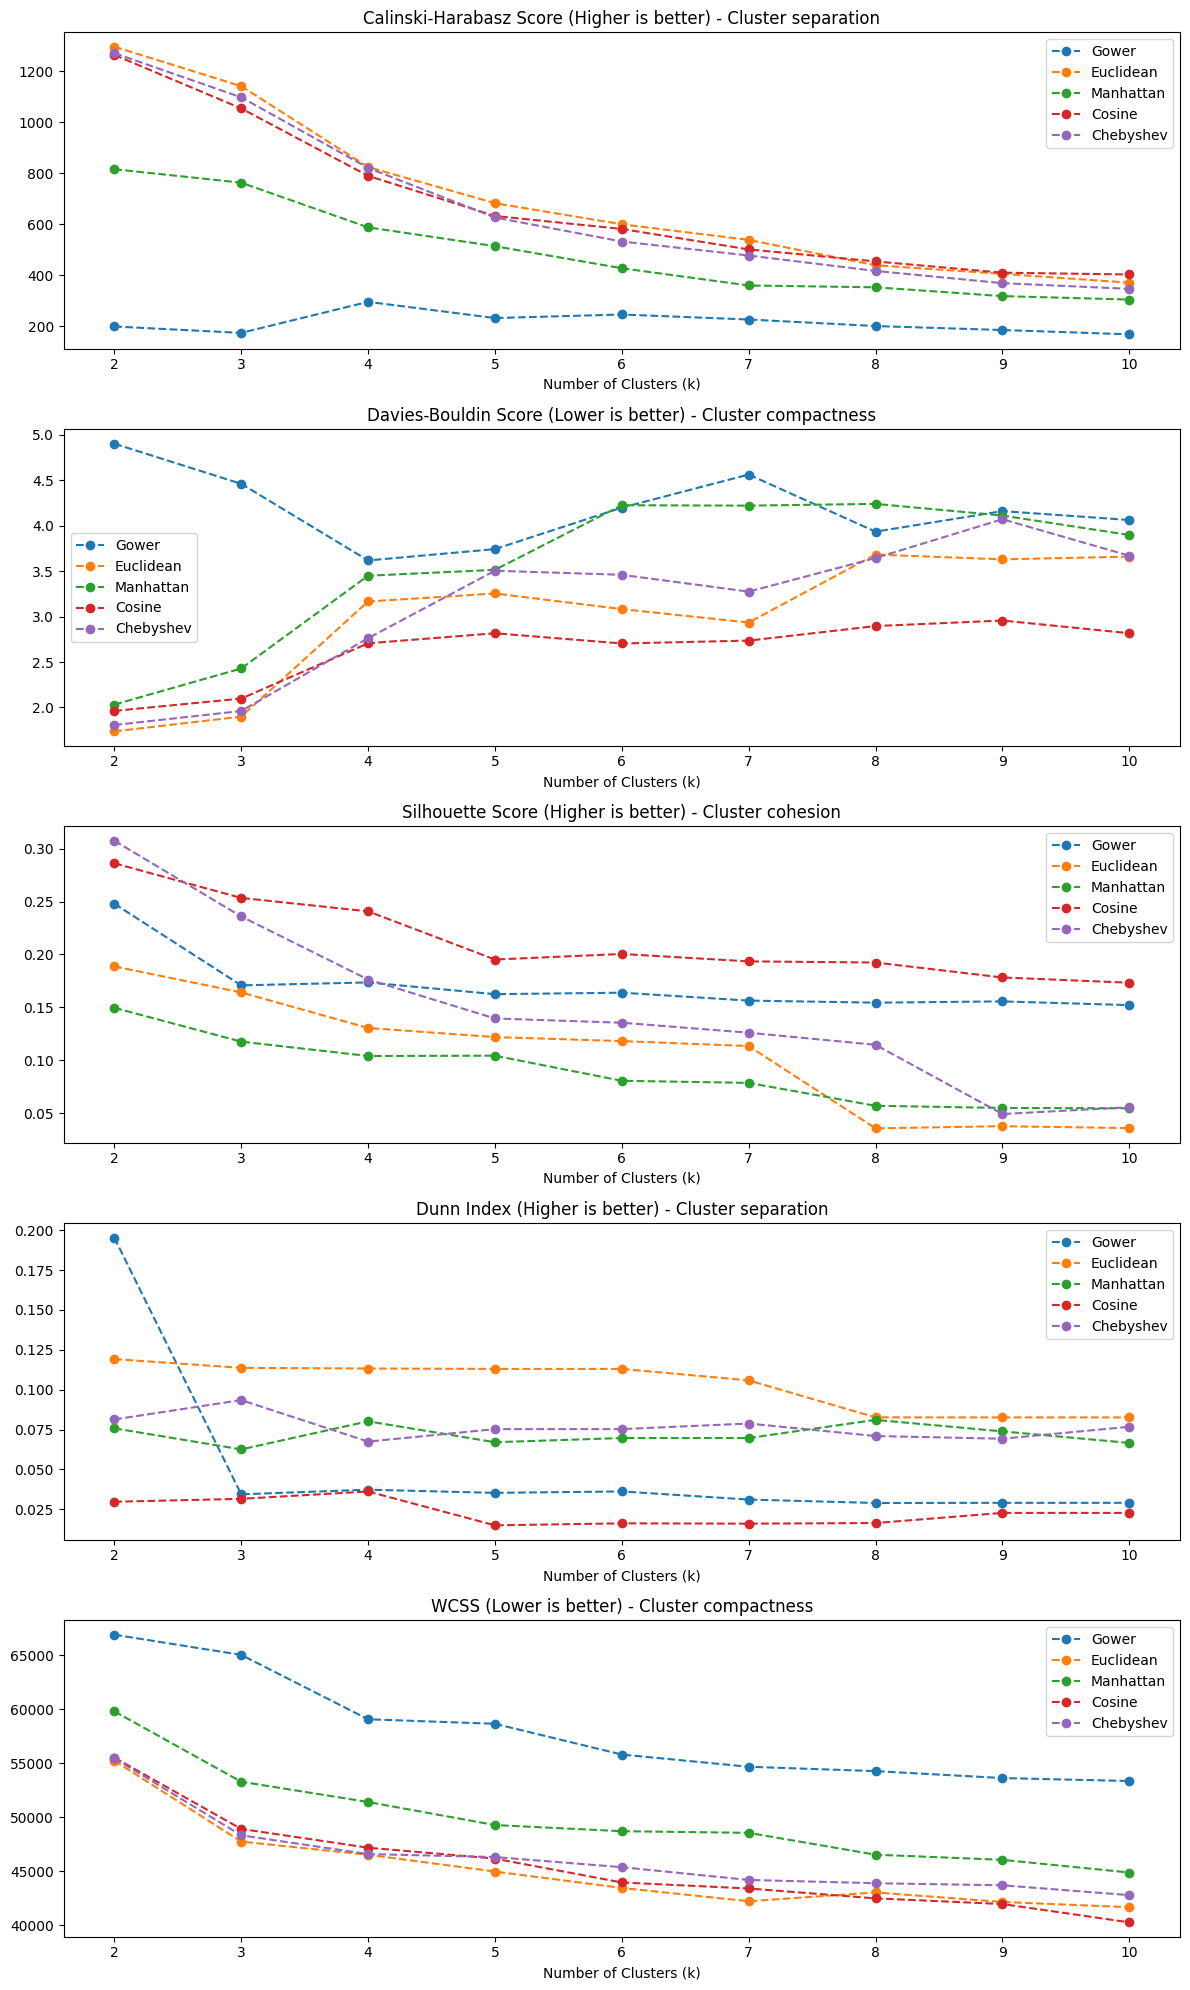


🔹 Best k values for Gower Distance:
✅ Optimal k (CH - Separation): 4
✅ Optimal k (DB - Compactness): 4
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 2
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Euclidean Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 2
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Manhattan Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 8
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Cosine Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 4
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Chebyshev Distance:
✅ Optimal k (CH - Separati

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.spatial.distance import pdist

# Compute Dunn Index
def dunn_index(dist_matrix, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []
    
    for cluster in unique_clusters:
        cluster_points = np.where(labels == cluster)[0]
        other_points = np.where(labels != cluster)[0]
        
        intra_dists.append(np.max(dist_matrix[np.ix_(cluster_points, cluster_points)]))
        inter_dists.append(np.min(dist_matrix[np.ix_(cluster_points, other_points)]))
    
    return np.min(inter_dists) / np.max(intra_dists)

# Compute Cohesion & Separation
def cohesion_separation(X, labels):
    unique_clusters = np.unique(labels)
    cohesion = sum([np.sum(pdist(X[labels == cluster])) for cluster in unique_clusters])
    separation = sum([np.sum(pdist(X[labels != cluster])) for cluster in unique_clusters])
    return cohesion, separation

# Compute WCSS (Within-Cluster Sum of Squares)
def compute_wcss(X, labels):
    unique_clusters = np.unique(labels)
    wcss = sum([np.sum((X[labels == cluster] - np.mean(X[labels == cluster], axis=0)) ** 2) for cluster in unique_clusters])
    return wcss

# Evaluate clustering for all distance metrics
def evaluate_clustering(X, cluster_results, distance_matrices):
    metrics = ["Gower", "Euclidean", "Manhattan", "Cosine", "Chebyshev"]
    
    # Store scores for each metric
    scores = {metric: {"CH": [], "DB": [], "Silhouette": [], "Dunn": [], "WCSS": []} for metric in metrics}

    for metric in metrics:
        print(f"\n🔹 Evaluating Clustering Performance for {metric} Distance")
        k_values = list(cluster_results[metric].keys())
        
        for k in k_values:
            labels = cluster_results[metric][k]
            distance_matrix = distance_matrices[metric]

            try:
                scores[metric]["CH"].append(calinski_harabasz_score(X, labels))  # Higher is better - Cluster separation
                scores[metric]["DB"].append(davies_bouldin_score(X, labels))  # Lower is better - Cluster compactness
                scores[metric]["Silhouette"].append(silhouette_score(distance_matrix, labels, metric='precomputed'))  # Higher is better - Cluster cohesion
                scores[metric]["Dunn"].append(dunn_index(distance_matrix, labels))  # Higher is better - Cluster separation
                scores[metric]["WCSS"].append(compute_wcss(X, labels))  # Lower is better - Cluster compactness
            except ValueError as e:
                print(f"⚠️ Skipping k={k} for {metric} due to an error: {e}")
                scores[metric]["CH"].append(np.nan)
                scores[metric]["DB"].append(np.nan)
                scores[metric]["Silhouette"].append(np.nan)
                scores[metric]["Dunn"].append(np.nan)
                scores[metric]["WCSS"].append(np.nan)

    # Plot metrics for comparison
    fig, axes = plt.subplots(5, 1, figsize=(12, 20))
    metric_details = [
        ("Calinski-Harabasz Score (Higher is better) - Cluster separation", "CH"),
        ("Davies-Bouldin Score (Lower is better) - Cluster compactness", "DB"),
        ("Silhouette Score (Higher is better) - Cluster cohesion", "Silhouette"),
        ("Dunn Index (Higher is better) - Cluster separation", "Dunn"),
        ("WCSS (Lower is better) - Cluster compactness", "WCSS")
    ]

    for idx, (metric_name, score_key) in enumerate(metric_details):
        for metric in metrics:
            axes[idx].plot(k_values, scores[metric][score_key], marker='o', linestyle='--', label=metric)

        axes[idx].set_title(metric_name)
        axes[idx].set_xlabel("Number of Clusters (k)")
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

    # Find the best k for each distance metric
    for metric in metrics:
        print(f"\n🔹 Best k values for {metric} Distance:")
        print(f"✅ Optimal k (CH - Separation): {k_values[np.argmax(scores[metric]['CH'])]}")
        print(f"✅ Optimal k (DB - Compactness): {k_values[np.argmin(scores[metric]['DB'])]}")
        print(f"✅ Optimal k (Silhouette - Cohesion): {k_values[np.argmax(scores[metric]['Silhouette'])]}")
        print(f"✅ Optimal k (Dunn - Separation): {k_values[np.argmax(scores[metric]['Dunn'])]}")
        print(f"✅ Optimal k (WCSS - Compactness, Elbow Expected): {k_values[np.argmin(scores[metric]['WCSS'])]}")

    return scores

# Evaluate clustering for all distance metrics
clustering_scores = evaluate_clustering(X_preprocessed, cluster_results, distance_matrices)

In [107]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Use Euclidean distance with 4 clusters
distance_metric = "Euclidean"
num_clusters = 3

dist_matrix = distance_matrices[distance_metric]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    raise ValueError(f"⚠️ {distance_metric} distance matrix contains NaN or Inf values. Check your preprocessing!")

if dist_matrix.shape[0] != dist_matrix.shape[1]:
    raise ValueError(f"⚠️ {distance_metric} distance matrix must be square (NxN).")

# Check if the selected number of clusters exists
if num_clusters not in cluster_results[distance_metric]:
    raise ValueError(f"⚠️ num_clusters={num_clusters} is not in cluster_results[{distance_metric}]. Check clustering output!")

labels = cluster_results[distance_metric][num_clusters]

# Compute 3D t-SNE projection
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels})

# Generate interactive 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df_plot['x'],
        y=df_plot['y'],
        z=df_plot['z'],
        mode='markers',
        marker=dict(
            size=5,  # Explicitly setting the size
            color=df_plot['Cluster'],  # Color by cluster
            colorscale='Turbo',  # Set color scale
            opacity=0.7  # Adjust transparency
        )
    )
])

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization ({distance_metric} Distance, k={num_clusters})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=800,  # Adjusted figure width
    height=800   # Adjusted figure height
)

fig.show()

In [108]:
import pandas as pd
from IPython.display import display
import numpy as np

# Ensure OneHotEncoder is fitted before retrieving feature names
if not hasattr(encoder, 'get_feature_names_out'):
    raise ValueError("⚠️ Encoder is not fitted. Ensure OneHotEncoder is properly trained before extracting feature names.")

# Get the actual feature names from OneHotEncoder
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
all_feature_names = numerical_features_reduced.columns.tolist() + list(encoded_feature_names)

# Ensure feature names match the shape of X_preprocessed
if len(all_feature_names) != X_preprocessed.shape[1]:
    raise ValueError(f"⚠️ Mismatch detected: {len(all_feature_names)} feature names but {X_preprocessed.shape[1]} columns in X_preprocessed.\nCheck preprocessing pipeline.")

# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Reverse Standard Scaling to restore original numerical values
summary_original_scale = summary.copy()
if set(numerical_features_reduced.columns).issubset(summary_original_scale.columns):
    try:
        summary_original_scale[numerical_features_reduced.columns] = scaler.inverse_transform(summary[numerical_features_reduced.columns])
    except ValueError as e:
        raise ValueError(f"⚠️ Error in inverse transformation: {e}.\nCheck if scaler was correctly fitted on the same number of features.")
else:
    raise ValueError("⚠️ Some numerical columns are missing in the summary. Check feature selection and scaling consistency.")

# Clip numerical values to realistic ranges (e.g., age, income limits)
if 'Age' in summary_original_scale.columns:
    summary_original_scale['Age'] = summary_original_scale['Age'].clip(lower=18, upper=100)  # Adjust realistic age limits

# Convert one-hot encoded categorical values back to original labels
for cat_col in categorical_columns:
    one_hot_columns = [col for col in summary_original_scale.columns if col.startswith(cat_col + "_")]
    
    if one_hot_columns:
        summary_original_scale[cat_col] = summary_original_scale[one_hot_columns].idxmax(axis=1).str.split('_').str[1]
        summary_original_scale = summary_original_scale.drop(columns=one_hot_columns)

# Display the DataFrame as a readable table
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)

ValueError: ⚠️ Mismatch detected: 28 feature names but 26 columns in X_preprocessed.
Check preprocessing pipeline.